In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
import matplotlib.colors as colors
from matplotlib import ticker
import numpy as np
import plotly.express as px
import math

In [155]:
import plotly.io as pio
pio.renderers.default = "svg"

In [156]:
database = r".\MT.xlsx"

# Área dos formigueiros

Realizar a leitura da base de dados

In [157]:
dataset_initial = pd.read_excel(database)

Separar a base de dados, deixando apens os campos que serão utilizados.  
Remover pontos de GPS sem ninhos.  
Remover linhas com valores vazios.

In [158]:
dataset = dataset_initial[['VL_LARG','VL_COMP','ID_CONDI','ID_ESPECIE','VL_OAD']]
dataset = dataset.loc[dataset['ID_CONDI'] != 0]
dataset = dataset.dropna()

Define o grupo de formiga com base na espécie.

In [159]:
especie_grupo = {
    0:0,
    1:1,
    2:2,
    3:3,
    4:1,
    5:1,
    6:2
}

def escolhe_grupo(especie:int):
    '''
    # Método Escolhe Grupo
    Retorna o código do grupo de formiga.

    ::

        especie[int] -> return int
    '''
    return especie_grupo[especie]

In [160]:
dataset['ID_GRUPO'] = dataset['ID_ESPECIE'].apply(lambda x: escolhe_grupo(x))

Retorna os valores distintos dos grupos.

In [161]:
unique_grupo = dataset['ID_GRUPO'].unique()

In [162]:
unique_grupo.sort()

In [163]:
nome_grupo = {
    1:'Saúva',
    2:'Quenquem',
    3:'Olheiro alimentação',
}

Cria o campo de tamanho em m² do ninho.

In [164]:
dataset = dataset.assign(VL_AREA_F = dataset['VL_LARG'] * dataset['VL_COMP'])

In [165]:
for row in dataset.itertuples():
    if(row[5]) == 0:
        dataset.at[row.Index, "VL_COMP_2"] = dataset.at[row.Index, "VL_COMP"]

    if( (row[5] > 0) and (row[7] < 1) ):
        dataset.at[row.Index, "VL_COMP_2"] = (1 + dataset.at[row.Index, "VL_OAD"]) / dataset.at[row.Index, "VL_LARG"]

    if( (row[5] > 0) and (row[7] >= 1) ):
        dataset.at[row.Index, "VL_COMP_2"] = (dataset.at[row.Index, "VL_AREA_F"] + dataset.at[row.Index, "VL_OAD"]) / dataset.at[row.Index, "VL_LARG"]

In [166]:
unique_grupo

array([1, 3], dtype=int64)

In [167]:
num_charts = len(unique_grupo)

In [168]:
# dataset.sort_values(by='VL_LARG',axis=0)

Realiza o calculo para determinar quanto desproporcional o ninho se encontra.

In [169]:
dataset = dataset.assign(DISTANCE_CENTROID = 0)

In [170]:
for row in dataset.itertuples():
        dataset.at[row.Index, "DISTANCE_FROM_INITIAL_POINT"] = math.dist([1,1], [row[1], row[2]])

In [171]:
#dataset.sort_values('DISTANCE_FROM_INITIAL_POINT', ascending=False)

Plota os gráficos para todos os grupos.

In [172]:
def calculateCentroid(xList, yList, coordinates):
    xCenter = np.sum(xList)/len(xList)
    yCenter = np.sum(yList)/len(yList)

    coordinates.append(xCenter)
    coordinates.append(yCenter)
    
    return coordinates

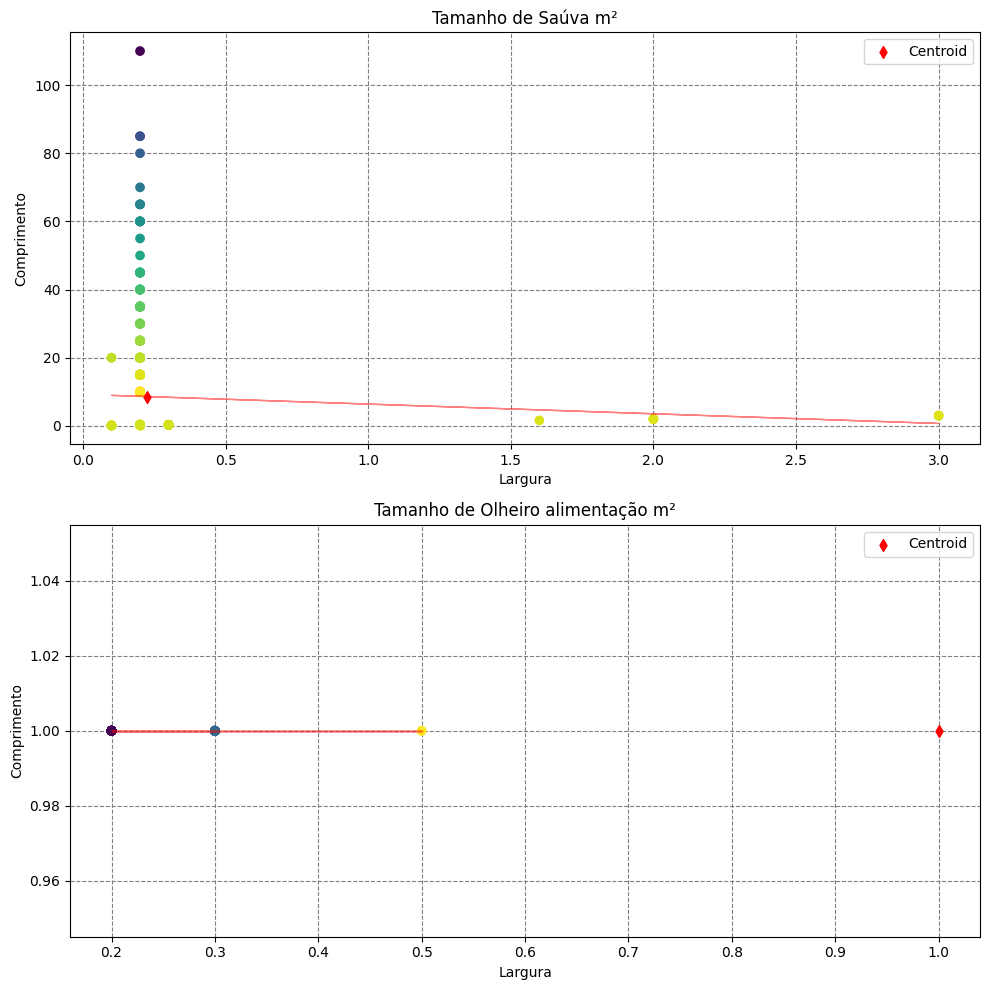

In [177]:
if num_charts == 1: num_charts+=1
fig, ax = plt.subplots(num_charts)
fig.set_size_inches(10, 10)

for index, grupo in enumerate(unique_grupo):

    coordinatesCenter = []

    dataset_filter = dataset.loc[dataset['ID_GRUPO'] == grupo]

    max = dataset_filter['VL_COMP_2'].max() if dataset_filter['VL_COMP_2'].max() > dataset_filter['VL_LARG'].max() else dataset_filter['VL_LARG'].max()
    start, end = (0, max+1)

    ax[index].set_axisbelow(True)

    ax[index].set_xlabel('Largura')
    ax[index].set_ylabel('Comprimento')

    ax[index].grid(linestyle='dashed', color='gray')

    if int(grupo) == 3: 
        coordinatesCenter = [1,1]
    else: 
        calculateCentroid(dataset_filter['VL_LARG'], dataset_filter['VL_COMP_2'], coordinatesCenter)

    for row in dataset_filter.itertuples():
        dataset.at[row.Index, "DISTANCE_CENTROID"] = math.dist(coordinatesCenter, [row[1], row[8]])

        # if(row.VL_LARG < coordinatesCenter[0]):
        #     if(row.VL_LARG > 0.1):
        #         dataset.at[row.Index, "DISTANCE_CENTROID"] = 0
        #     else:
        #         dataset.at[row.Index, "DISTANCE_CENTROID"] = (dataset.at[row.Index, "DISTANCE_CENTROID"] + 1.44)



    ax[index].scatter(
        x=dataset_filter['VL_LARG'],
        y=dataset_filter['VL_COMP_2'],
        c=dataset_filter['DISTANCE_CENTROID'],
        cmap="viridis_r",
        alpha=1)
    c = ax[index].scatter(coordinatesCenter[0], coordinatesCenter[1], color='red', marker="d", label="Centroid")

    ax[index].set_title(f"Tamanho de {nome_grupo[grupo]} m²")

    z = np.polyfit(dataset_filter['VL_LARG'], dataset_filter['VL_COMP_2'], 1)
    p = np.poly1d(z)

    ax[index].plot(dataset_filter['VL_LARG'], p(dataset_filter['VL_LARG']), linewidth=1, color='red', alpha=0.5)
    ax[index].legend(handles=[c],scatterpoints=1)

    fig.tight_layout()


plt.savefig(f'mining.pdf', dpi=300)

In [174]:
# unique_grupo = [1]
# for index, grupo in enumerate(unique_grupo):

#     coordinatesCenter = []

#     dataset_filter = dataset.loc[dataset['ID_GRUPO'] == grupo]

#     if int(grupo) == 3:
#         coordinatesCenter = [1,1]
#     else:
#         calculateCentroid(dataset_filter['VL_LARG'], dataset_filter['VL_COMP_2'], coordinatesCenter)

#     for row in dataset_filter.itertuples():
#         dataset.at[row.Index, "DISTANCE_CENTROID"] = math.dist(coordinatesCenter, [row[1], row[8]])

#         # if(row.VL_LARG < coordinatesCenter[0]):
#         #     if(row.VL_LARG > 0.1):
#         #         dataset.at[row.Index, "DISTANCE_CENTROID"] = 0
#         #     else:
#                 # dataset.at[row.Index, "DISTANCE_CENTROID"] = (dataset.at[row.Index, "DISTANCE_CENTROID"] + 1.44)

#     fig2 = go.Figure(
#         data = go.Scattergl(
#             x=dataset_filter["VL_LARG"],
#             y=dataset_filter["VL_COMP_2"],
#             mode='markers',
#             marker_color=dataset_filter['DISTANCE_CENTROID'],
#             text=dataset_filter['DISTANCE_CENTROID'],
#             marker=dict(
#                 color=dataset_filter["DISTANCE_CENTROID"],
#                 colorscale='Viridis_r',
#                 line_width=1,
#                 showscale=True,
#             ),
#             showlegend=False
#         )
#     )


#     fig2.update_layout(
#         height=800,
#         title_text=f"Tamanho de {nome_grupo[grupo]} m²"
#     )
# #     fig2.add_trace(
# #     go.Scatter(
# #         mode='markers',
# #         marker_symbol = 'diamond-tall',
# #         x=[coordinatesCenter[1]],
# #         y=[coordinatesCenter[0]],
# #         text="Centroid",
# #         marker=dict(
# #             color='red',
# #             size=12,
# #         ),
# #         showlegend=False
# #     )
# # )

#     # fig2.show(renderer='svg')